In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Virtual EVE From Pretrained Embeddings

### Background
This notebook provides two examples of finetuning SDOFM for scientific use cases. First we finetune a virtual eve virtual instrument starting from a SDOFM pretrained foundation model, accomplishing a production ready model much faster and resource efficient than training from scratch. As a second example, we finetune train a missing data data generator

#### Foundation Models
In principle, one may train an AI model from scratch for a variety of SDO data-driven use cases. This is a wasteful process however as all models have a common foundational training on the same SDO dataset. The aim of producing a foundation model for SDO use cases is to avoid this inefficient process; we first run a process called pretraining to generate a base model that one can think of as a compressed representation of the dataset it was trained on, in this case SDO, and start from there. A loose analogy would be that to building a space elevator for launching new space vessels. 

This process of training a common foundation model from which many others can be adapted is akin to that of transfer learning, a method that has been around for about 15 years or so. For an extensive treatment of transfer learning please see [review paper](https://arxiv.org/abs/1811.08883). The creation of a foundation model takes this theoretical underpinning further by conducting the foundational model training on a much larger dataset, with a much larger model, which is thought to have the expressivity capable of understanding deep underlying dynamics in the data. This could be considered the holy grail of scientific foundation models; to train a massive neural network on a massive dataset such as that from CERN's Large Hadron Collider, and somehow have the model express back to us the Standard Model of Particle Physics.

##### Typical Foundation Model Architectures
Over the course of the past few years AI researchers have began to converge on architectures that lend themselves well to the foundation model archetype. Typically the pretrained portion of the neural network that is later then repurposed for specific use cases is called the "Head". The Head can be thought of a feature extractor; that is, a function $f(.)$ that maps input data, for example AIA images, to a compressed latent space representation which underlines the important dynamics present in this sample. Though this latent space representation is encoded in a digital language unbenownst to us, this latent space "language" representation underlines the important aspects of this sample such as if it may contain active regions, or if it is part of a calm solar cycle. This latent space representation is learned from the data itself with no other input; understanding how to further encode our current physics understanding relevant to various foundation models is an open area of research.

Only the head is trained during model pretraining, the resulting trained model being what we call a foundation model. Once created, the foundation model can be utilized by the scientific community at large for their own particular studies without needing the burden of the expensive and resource requirements to train a large foundation model. This is for example what Meta does by sharing the pretrained model weights of it's llama family of models so researchers and practicioners do not have to begin from scratch everytime. Reproducing this approach for specific scientific domains is the main aim and motivation of the SDOFM collaboration.

![Figure 1: Architectural Diagram](assets/architecture_diags_pretraining.svg)

### Setting up the environment [skip if on running sdofm.org!]
For this section, please be sure to be located in the project root directory before executing any commands. None of the cells in this section are meant to be ran from the notebook IDE, but rather your terminal.

#### System Requirements
This tutorial assumes that you have conda or miniconda installed and are on a linux or macos machine. It's advisable to install miniconda if you have to decide between the two (smaller install), however, if you already have conda installed, you can skip on to the next step.

For instructions on installing miniconda, please see [Miniconda Installation](https://docs.anaconda.com/miniconda/miniconda-install/).

##### Python environment setup
After you're sure you have conda installed on your system, please run the following command from the project root directory to install a new conda environment

```bash
conda env create -f notebooks/camera_ready/virtual_eve/conda_env.yml

# Activate the newly created environment with:
conda activate virtual-eve-finetuning

# Next, install the required python libraries:
pip install -r notebooks/camera_ready/virtual_eve/requirements.txt

# Also the local sdofm package:
pip install -e .
```
Lastly, make sure to select the correct python kernel associated with this environment, (likely located in `${CONDA_PREFIX_1}/envs/virtual-eve-finetuning/bin/python`)

Nice, you should now be all set to go!

### Getting started

We begin by importing the newly installed libraries we will need tp run this notebook. Note: the import cell below is the first one you should be executing in this notebook.

In [48]:
import os
import omegaconf
from sdofm.datasets import SDOMLDataModule
import numpy as np

Next, let's load the appropriate configuration file for this run: 

In [49]:
cfg = omegaconf.OmegaConf.load("finetune_virtualeve_config.yml")

This configuration file specifies various parameters for the model run such as 

- Experiment Config: Where to find the opensource pretrained model weights
- Data configuration: where to load the input data from, data metadata, etc
- Run parameters: Number of epochs, etc
- Misc: log levels, etc.

We can interrogate the values in the configuration file by either opening the configuration file itself, or printing the values:

In [50]:
dict(cfg)

{'log_level': 'DEBUG',
 'experiment': {'name': None, 'project': 'sdofm', 'task': 'finetune', 'model': 'virtualeve', 'resuming': False, 'checkpoint': None, 'backbone': {'checkpoint': 'assets/model.ckpt', 'model': 'mae'}, 'seed': 0, 'disable_cuda': False, 'wandb': {'enable': False, 'entity': '', 'group': '', 'job_type': 'finetune', 'tags': [], 'notes': '', 'output_directory': 'wandb_output', 'log_model': 'all'}, 'gcp_storage': {'enabled': True, 'bucket': 'sdofm-checkpoints'}, 'fold': None, 'evaluate': False, 'device': None, 'precision': 'bf16-true', 'log_n_batches': 1000, 'save_results': True, 'accelerator': 'auto', 'profiler': None, 'distributed': {'enabled': True, 'world_size': 'auto', 'strategy': 'ddp_find_unused_parameters_true'}, 'log_every_n_steps': 5},
 'data': {'min_date': '2011-10-01 00:00:00.00', 'max_date': '2011-12-31 23:59:59.99', 'month_splits': {'val': [11], 'test': [12], 'holdout': []}, 'num_workers': 4, 'prefetch_factor': 3, 'num_frames': 1, 'drop_frame_dim': False, 'sdo

Next, we load the SDOMLDataModule, which defines how we interact with the training dataset for the finetuning:

In [51]:
data_module = SDOMLDataModule(
     hmi_path=(
         os.path.join(
            cfg.data.sdoml.base_directory,
            cfg.data.sdoml.sub_directory.hmi,
        )
        if cfg.data.sdoml.sub_directory.hmi
        else None
    ),
    aia_path=(
        os.path.join(
            cfg.data.sdoml.base_directory,
            cfg.data.sdoml.sub_directory.aia,
        )
        if cfg.data.sdoml.sub_directory.aia
        else None
    ),
    eve_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.eve
    ),
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.cache
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
    num_frames=cfg.data.num_frames,
    drop_frame_dim=cfg.data.drop_frame_dim,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_HMI_FULL_AIA_FULL_EVE_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_HMI_FULL_AIA_FULL_EVE_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


Let's take a look at our data

In [52]:
imgs, eve = next(iter(data_module.train_ds))

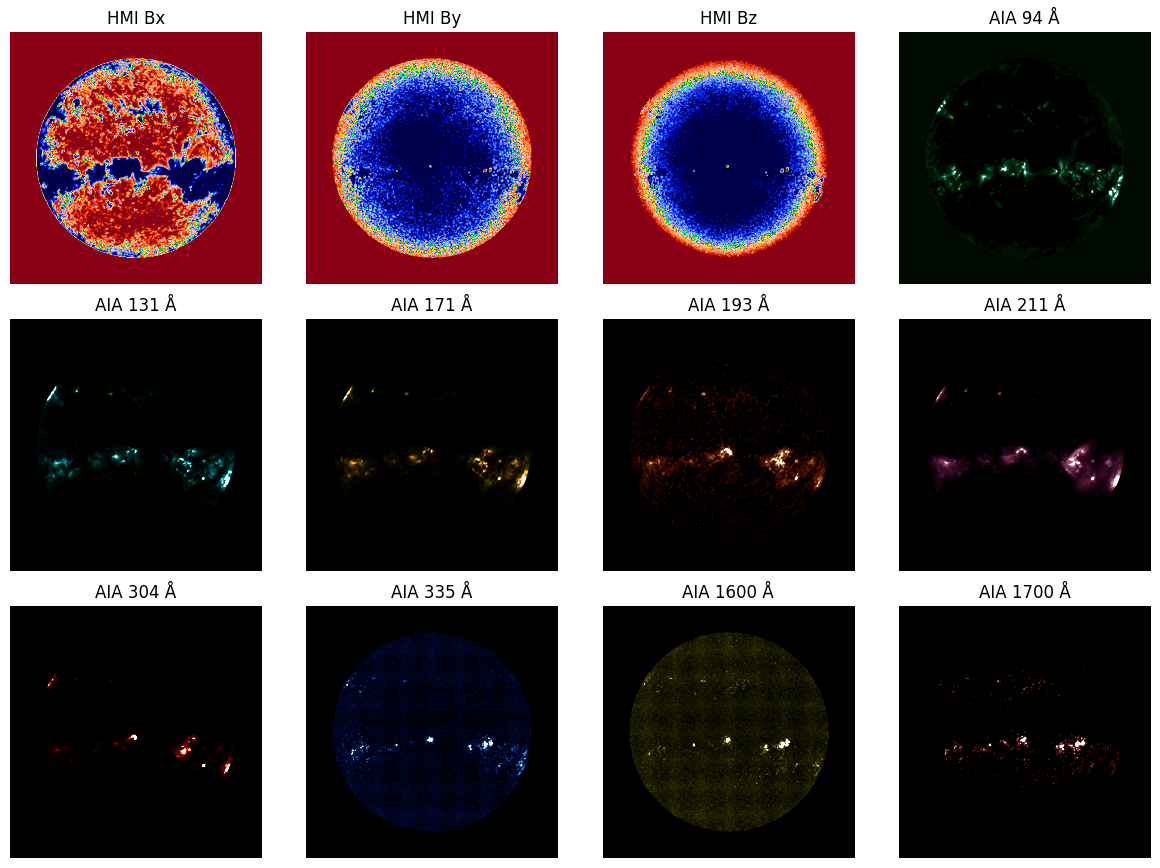

In [57]:
from sdofm.visualisation import sdo_plot
import torch
sdo_plot(torch.tensor(imgs[:,0,:,:]), data_normalized=True)

## Create a finetuning model
Now time to get serious, this model will become our model's "head." The objective of this component is to take now a set of finetuned embeddings and have them predict our true science task. This model was created during FDL-X 2023 and is used as an quick example. It has a switching mode that transitions the model from linear to influenced by a CNN after a defned number of epochs. We're going to do this with Pytorch Lighning for keep hardware agnostic. 

We first import necessary components.

In [58]:
import torch 
import torch.nn as nn
import torchvision
from sdofm import BaseModule
import sys
from sdofm.models.virtualeve import unnormalize

We first define the simple linear model.

In [59]:
class LinearIrradianceModel(BaseModule):
    def __init__(self, d_input, d_output, eve_norm):
        super().__init__()
        # self.eve_norm = eve_norm
        self.n_channels = d_input
        self.outSize = d_output

        self.model = nn.Linear(2 * self.n_channels, self.outSize)
        self.loss_func = nn.HuberLoss()  # consider MSE

    def forward(self, x):
        mean_irradiance = torch.mean(x, dim=(2, 3))
        std_irradiance = torch.std(x, dim=(2, 3))
        x = self.model(torch.cat((mean_irradiance, std_irradiance), dim=1))
        return x

Then the CNN efficientnet model.

In [60]:
class CNNIrradianceModel(BaseModule):
    def __init__(self, d_input, d_output, eve_norm, dp=0.75):
        super().__init__()

        model = torchvision.models.efficientnet_b3(weights="IMAGENET1K_V1")
        conv1_out = model.features[0][0].out_channels
        model.features[0][0] = nn.Conv2d(
            d_input,
            conv1_out,
            kernel_size=(3, 3),
            stride=(2, 2),
            padding=(1, 1),
            bias=False,
        )

        lin_in = model.classifier[1].in_features
        classifier = nn.Sequential(
            nn.Dropout(p=dp, inplace=True),
            nn.Linear(in_features=lin_in, out_features=d_output, bias=True),
        )
        model.classifier = classifier

        for m in model.modules():
            if m.__class__.__name__.startswith("Dropout"):
                m.p = dp

        self.model = model
        self.loss_func = nn.HuberLoss()

    def forward(self, x):
        x = self.model(x)
        return x

Finally, we create the hybrid switching model.

In [104]:
class HybridIrradianceModel(BaseModule):

    def __init__(
        self,
        d_input,
        d_output,
        eve_norm,
        *args,
        lr_linear=0.01,
        lr_cnn=0.0001,
        cnn_dp=0.75,
        ln_params=None,  # used in lambda function out of scope?
        epochs_linear=None,  # out of scope
        **kwargs,
    ):

        super().__init__(*args, **kwargs)
        # self.eve_norm = torch.Tensor(self.eve_norm).float() #eve_norm
        self.register_buffer("eve_norm", torch.Tensor(eve_norm).float())
        self.n_channels = d_input
        self.outSize = d_output
        # self.ln_params = ln_params # unused
        self.lr_linear = lr_linear
        self.lr_cnn = lr_cnn
        self.train_mode = "linear"

        self.ln_model = LinearIrradianceModel(self.n_channels, d_output, eve_norm)
        self.cnn_model = CNNIrradianceModel(
            d_input, d_output, eve_norm, dp=cnn_dp
        )
        self.loss_func = nn.HuberLoss()

    def forward(self, x):
        return self.ln_model.forward(x) + self.cnn_lambda * self.cnn_model.forward(x)

    def forward_unnormalize(self, x):
        return self.unnormalize(self.forward(x))

    def unnormalize(self, y):
        # eve_norm = torch.tensor(self.eve_norm).float()
        norm_mean = self.eve_norm[0]
        norm_stdev = self.eve_norm[1]
        y = y * norm_stdev[None] + norm_mean[None]  # .to(y) .to(y)
        return y

    def training_step(self, batch, batch_nb):
        x, y = batch
        y_pred = self.forward(x)
        loss = self.loss_func(y_pred, y)

        # print("t: trying un")
        y = self.unnormalize(y)
        y_pred = self.unnormalize(y_pred)
        # print("t: success un")

        epsilon = sys.float_info.epsilon
        # computing relative absolute error
        rae = torch.abs((y - y_pred) / (torch.abs(y) + epsilon)) * 100
        av_rae = rae.mean()

        self.log_everything("train", loss, av_rae, float(self.cnn_lambda))
        return loss

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_pred = self.forward(x)
        loss = self.loss_func(y_pred, y)

        y = self.unnormalize(y)
        y_pred = self.unnormalize(y_pred)

        epsilon = sys.float_info.epsilon
        # computing relative absolute error
        rae = torch.abs((y - y_pred) / (torch.abs(y) + epsilon)) * 100
        av_rae = rae.mean()
        av_rae_wl = rae.mean(0)
        # compute average cross-correlation
        cc = torch.tensor(
            [
                torch.corrcoef(torch.stack([y[i], y_pred[i]]))[0, 1]
                for i in range(y.shape[0])
            ]
        ).mean()
        # compute mean absolute error
        mae = torch.abs(y - y_pred).mean()

        self.log_everything(
            "val", loss, av_rae, float(self.cnn_lambda), av_rae_wl, mae, cc
        )

        return loss

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_pred = self.forward(x)
        loss = self.loss_func(y_pred, y)

        y = self.unnormalize(y)
        y_pred = self.unnormalize(y_pred)

        epsilon = sys.float_info.epsilon
        rae = torch.abs((y - y_pred) / (torch.abs(y) + epsilon)) * 100
        av_rae = rae.mean()
        av_rae_wl = rae.mean(0)
        # compute average cross-correlation
        cc = torch.tensor(
            [
                torch.corrcoef(torch.stack([y[i], y_pred[i]]))[0, 1]
                for i in range(y.shape[0])
            ]
        ).mean()
        # mean absolute error
        mae = torch.abs(y - y_pred).mean()

        self.log_everything(
            "test", loss, av_rae, float(self.cnn_lambda), av_rae_wl, mae, cc
        )

        return loss

    def log_everything(
        self, mode, loss, av_rae, train_lambda_cnn, av_rae_wl=None, mae=None, cc=None
    ):
        # the .to() calls are a fix for https://github.com/Lightning-AI/pytorch-lightning/issues/18803
        self.log(
            f"{mode}_loss",
            loss,
            prog_bar=True,
        )
        self.log(
            f"{mode}_RAE",
            av_rae,
        )

    def configure_optimizers(self):
        return torch.optim.Adam(
            [
                {"params": self.ln_model.parameters()},
                {"params": self.cnn_model.parameters(), "lr": self.lr_cnn},
            ],
            lr=self.lr_linear,
        )

    def set_train_mode(self, mode):
        if mode == "linear":
            self.train_mode = "linear"
            self.cnn_lambda = 0.0
            self.cnn_model.freeze()
            self.ln_model.unfreeze()
        elif mode == "cnn":
            self.train_mode = "cnn"
            self.cnn_lambda = 0.01
            self.cnn_model.unfreeze()
            self.ln_model.freeze()
        else:
            raise NotImplemented(f"Mode not supported: {mode}")


Collect the backbone model. In this example we're loading a Masked Autoencoder and an NVAE for comparison.

In [62]:
from pretrain import Pretrainer
MAE = Pretrainer(cfg, logger=None, is_backbone=True)

Using <class 'sdofm.datasets.SDOML.SDOMLDataModule'> Data Class
[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.
Loading checkpoint...
Done


## Define the full models

![Figure 2: Architectural Diagram of Virtual EVE Finetuning](assets/architecture_diags_virtualeve_finetuning.svg)

Now that we have a suitable head model completing our objective, predicting EVE from the AIA instrument we can construct our full model. This is broken down by the sections as defined in the figure above. The backbone is set into finetuning mode and the encoder is explictly frozen. These outputs are fed into a decoding layer before they are ready for non-transformer models, such as our example above.

In [118]:
from sdofm.models import WrapEncoder, ConvTransformerTokensToEmbeddingNeck

class VirtualEVEModel(BaseModule):
    def __init__(
            self,
            # Backbone parameters
            img_size: int = 512,
            patch_size: int = 16,
            embed_dim: int = 128,
            num_frames: int = 1,
            # Neck parameters
            num_neck_filters: int = 32,
            # Head parameters
            # d_input=None,
            cnn_model: str = "efficientnet_b3",
            lr_linear: float = 0.01,
            lr_cnn: float = 0.0001,
            cnn_dp: float = 0.75,
            epochs_linear: int = 50,
            d_output=None,
            eve_norm=None,
            # for finetuning
            backbone: object = None,
            freeze_encoder: bool = True,
            # all else
            *args,
            **kwargs,
        ):
            super().__init__(*args, **kwargs)
            self.eve_norm = eve_norm

            self.backbone = backbone

            if freeze_encoder:
                self.backbone.autoencoder.blocks.eval()
                for param in self.backbone.autoencoder.blocks.parameters():
                    param.requires_grad = False

            num_tokens = img_size // patch_size

            # HEAD
            self.head = HybridIrradianceModel(
                # virtual eve
                d_input=9, # for number of wavelengths
                d_output=d_output, # number of ions
                eve_norm=eve_norm,
                # from config
                # cnn_model=cnn_model,
                lr_linear=lr_linear,
                lr_cnn=lr_cnn,
                cnn_dp=cnn_dp,
                # epochs_linear=epochs_linear,
            )

    def training_step(self, batch, batch_idx):
        imgs, eve = batch
        loss, x_hat, mask = self.backbone(imgs[:, :9, :, :])
        y_hat = self.head(x_hat[:,:,0,:,:])
        loss = self.head.loss_func(y_hat, eve[:, :38, 0])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, eve = batch
        loss, x_hat, mask = self.backbone(imgs[:, :9, :, :])
        y_hat = self.head(x_hat[:,:,0,:,:])
        loss = self.head.loss_func(y_hat, eve[:, :38, 0])
        self.log("val_loss", loss)

### Another option: Training only from the latents
![Figure 3: Architectural Diagram of Virtual EVE Training with Latents](assets/architecture_diags_virtualeve_latents.svg)

As the this foundation model includes an autoencoder archetecture use of the decoder is optional. The latents created by the autoencoder can be used directly, the below is an naive implementation. For a real-world use case you'd want to design the model around these new input.

In [64]:
from sdofm import BaseModule
from sdofm.models import WrapEncoder, ConvTransformerTokensToEmbeddingNeck

class VirtualEVELatentModel(BaseModule):
    def __init__(
            self,
            # Backbone parameters
            img_size: int = 512,
            patch_size: int = 16,
            embed_dim: int = 128,
            num_frames: int = 1,
            # Neck parameters
            num_neck_filters: int = 32,
            # Head parameters
            # d_input=None,
            cnn_model: str = "efficientnet_b3",
            lr_linear: float = 0.01,
            lr_cnn: float = 0.0001,
            cnn_dp: float = 0.75,
            epochs_linear: int = 50,
            d_output=None,
            eve_norm=None,
            # for finetuning
            backbone: object = None,
            use_latents: bool = True,
            # all else
            *args,
            **kwargs,
        ):
            super().__init__(*args, **kwargs)
            self.eve_norm = eve_norm

            self.backbone = backbone
            # self.encoder = WrapEncoder(self.backbone)

            if use_latents:
                self.encoder.eval()
                for param in self.encoder.parameters():
                    param.requires_grad = False

            num_tokens = img_size // patch_size

            # NECK
            self.decoder = ConvTransformerTokensToEmbeddingNeck(
                embed_dim=embed_dim,
                output_embed_dim=num_neck_filters,
                Hp=num_tokens,
                Wp=num_tokens,
                drop_cls_token=True,
                num_frames=num_frames,
            )

            # HEAD
            self.head = HybridIrradianceModel(
                # virtual eve
                d_input=num_neck_filters,
                d_output=d_output,
                eve_norm=eve_norm,
                # from config
                # cnn_model=cnn_model,
                lr_linear=lr_linear,
                lr_cnn=lr_cnn,
                cnn_dp=cnn_dp,
                # epochs_linear=epochs_linear,
            )

    def training_step(self, batch, batch_idx):
        imgs, eve = batch
        x = self.encoder(imgs[:, :9, :, :])
        y_hat = self.head(self.decoder(x))
        loss = self.head.loss_func(y_hat, eve[:, :38, 0])
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, eve = batch
        x = self.encoder(imgs[:, :9, :, :])
        y_hat = self.head(self.decoder(x))
        # print(eve.shape)
        loss = self.head.loss_func(y_hat, eve[:, :38, 0])
        self.log("val_loss", loss)

In [63]:
backbone = MAE.model

The finetuning model is then initialised with the params as defined in the experiment configuration file.

In [122]:
import lightning.pytorch as pl

backbone_params = {}
backbone_params["img_size"] = cfg.model.mae.img_size
backbone_params["patch_size"] = cfg.model.mae.patch_size
backbone_params["embed_dim"] = cfg.model.mae.embed_dim
backbone_params["num_frames"] = cfg.model.mae.num_frames

model = VirtualEVEModel(
    # backbone
    **backbone_params,
    # virtual eve params
    **cfg.model.virtualeve,
    d_output=len(data_module.ions),
    eve_norm=np.array(
        data_module.normalizations["EVE"]["eve_norm"],
        dtype=np.float32,
    ),
    # backbone
    backbone=backbone,
    hyperparam_ignore=["backbone"],
)

model.head.set_train_mode("linear")
callbacks = [(
        pl.callbacks.LambdaCallback(
            on_train_epoch_start=(
                lambda trainer, pl_module: (
                    model.head.set_train_mode("cnn")
                    if trainer.current_epoch
                    > cfg.model.virtualeve.epochs_linear
                    else None
                )
            )
        )
    )]

2024-07-23 22:17:00.287507: E external/tsl/tsl/distributed_runtime/coordination/coordination_service.cc:584] /job:jax_worker/replica:0/task:0 unexpectedly tried to connect with a different incarnation. It has likely restarted.
2024-07-23 22:17:00.290745: E external/tsl/tsl/distributed_runtime/coordination/coordination_service.cc:992] /job:jax_worker/replica:0/task:0 has been set to ERROR in coordination service: ABORTED: /job:jax_worker/replica:0/task:0 unexpectedly tried to connect with a different incarnation. It has likely restarted. [type.googleapis.com/tensorflow.CoordinationServiceError='\"\x0c\n\njax_worker']
2024-07-23 22:17:00.292540: E external/tsl/tsl/distributed_runtime/coordination/coordination_service.cc:584] /job:jax_worker/replica:0/task:0 unexpectedly tried to connect while it is already in error. ResetTask() should be called before a subsequent connect attempt.
2024-07-23 22:17:00.292571: E external/tsl/tsl/distributed_runtime/coordination/coordination_service.cc:992]

: 

## Model training

In [121]:
from lightning.pytorch import Trainer 
os.environ['PJRT_DEVICE'] = 'GPU'
trainer = Trainer(max_epochs=2, precision=32, callbacks=callbacks)
trainer.fit(model=model, datamodule=data_module)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]



  | Name     | Type                  | Params | Mode 
-----------------------------------------------------------
0 | backbone | MAE                   | 104 M  | eval 
1 | head     | HybridIrradianceModel | 10.8 M | train
-----------------------------------------------------------
27.8 M    Trainable params
87.5 M    Non-trainable params
115 M     Total params
461.245   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


## Now over to you? What would you like to see with models like these?

#### Acknowledgements
This work is the research product of the SDO-FM: A Multi-Modal Foundation Model POC for SDO (Grant#: 80NSSC24K0701); funded and supported by NASA. The research and its outputs have been designed, managed and delivered by Trillium Technologies Inc.

**Authors**

James Walsh, University of Cambridge  
Daniel Gass, University of Central Lancashire  
Raul Ramos Pollan, Universidad Industrial de Santander  
Richard Galvez, Pure Storage  
Paul Wright, Dublin Institute for Advanced Studies  
Atılım Güneş Baydin, University of Oxford  
Noah Kasmanoff, AE Studio   
Jason Naradowsky, University of Tokyo  

PI: Anne Spalding, Trillium Technolgies Inc  
Co-I: James Parr, Trillium Technologies Inc 